# Effect of repealing Child Tax Credit with Child Dividend

This identifies beneficiaries of the Child Tax Credit by modeling its repeal. Both repeal from current (2017) state and TCJA state are considered on a static basis. Change to after-tax income by decile and share of after-tax income held by top 10% are calculated.

*Data: CPS  |  Tax year: 2018  |  Type: Static  |  Author: Max Ghenis  |  Date run: 2018-02-20*

## Setup

### Imports

In [1]:
import taxcalc as tc
import pandas as pd
import numpy as np
import copy
from bokeh.io import show, output_notebook
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import urllib as url_lib  # On Python 3.6 use "import urllib.request as url_lib".

In [2]:
tc.__version__

'0.16.1'

In [503]:
sns.set_style('white')
DPI = 75
mpl.rc('savefig', dpi=DPI)
mpl.rcParams['figure.dpi']= DPI
mpl.rcParams['figure.figsize'] = 6.4, 4.8  # Default.

In [508]:
mpl.rcParams['font.sans-serif'] = 'Roboto-Regular'
mpl.rcParams['font.family'] = 'sans-serif'

# Set title text color to dark gray (https://material.io/color) not black.
TITLE_COLOR = '#212121'
mpl.rcParams['text.color'] = TITLE_COLOR

# Axis titles and tick marks are medium gray.
AXIS_COLOR = '#757575'
mpl.rcParams['axes.labelcolor'] = AXIS_COLOR
mpl.rcParams['xtick.color'] = AXIS_COLOR
mpl.rcParams['ytick.color'] = AXIS_COLOR

# Use Seaborn's default color palette.
# https://stackoverflow.com/q/48958426/1840471 for reproducibility.
sns.set_palette(sns.color_palette())

In [417]:
# Show one decimal in tables.
pd.set_option('precision', 2)

In [6]:
def gini(x, weights=None):
    if weights is None:
        weights = np.ones_like(x)
    # Calculate mean absolute deviation in two steps, for weights.
    count = np.multiply.outer(weights, weights)
    mad = np.abs(np.subtract.outer(x, x) * count).sum() / count.sum()
    # Gini equals half the relative mean absolute deviation.
    rmad = mad / np.average(x, weights=weights)
    return 0.5 * rmad

### Create policies

Load reforms from GitHub. Policies and reforms are named according to this convention:

**`{reform}_{year}_{object}`**

For example:

* `noctc_2017_policy`: Policy without CTC using 2017 law.
* `ubi_2018_calc`: Calculator replacing CTC with UBI using 2018 (current) law.

In [17]:
y2017_reform = {
    2018: {
        "_CTC_c": [1000.0],
        "_CTC_ps": [[75000.0, 110000.0, 55000.0, 75000.0, 75000.0]],
        "_ACTC_Income_thd": [3000.0],
        "_DependentCredit_Child_c": [0.0],
        "_DependentCredit_before_CTC": [0.0]
    }
}

noctc_reform = {
    2018: {
        '_CTC_c': [0],
        '_DependentCredit_Child_c': [0]
    }
}

### Specify `Calculator` objects for static analyses

In [8]:
recs = tc.Records.cps_constructor()

In [9]:
def static_baseline_calc(year):
    calc = tc.Calculator(records=recs, policy=tc.Policy())
    calc.advance_to_year(year)
    calc.calc_all()
    return calc

In [10]:
def weighted_sum(df, col):
    return (df[col] * df['s006']).sum()

In [11]:
def child_ubi_reform(amount):
    return {2018: {'_UBI_u18': [amount],
                   '_UBI_ecrt': [1.0]}}

In [383]:
def add_weighted_quantiles(df, col):
    df.sort_values(by=col, inplace=True)
    col_pctile = col + '_percentile_exact'
    df[col_pctile] = 100 * df['s006'].cumsum() / df['s006'].sum()
    # "Null out" negatives using -1, since integer arrays can't be NaN.
    # TODO: Should these be null floats?
    df[col_pctile] = np.where(df[col] >= 0, df[col_pctile], 0)
    # Reduce top record, otherwise it's incorrectly rounded up.
    df[col_pctile] = np.where(df[col_pctile] >= 99.99999, 99.99999, df[col_pctile])
    df[col + '_percentile'] = np.ceil(df[col_pctile]).astype(int)
    df[col + '_2percentile'] = np.ceil(df[col_pctile] / 2).astype(int)
    df[col + '_ventile'] = np.ceil(df[col_pctile] / 5).astype(int)
    df[col + '_decile'] = np.ceil(df[col_pctile] / 10).astype(int)
    df[col + '_quintile'] = np.ceil(df[col_pctile] / 20).astype(int)
    df[col + '_quartile'] = np.ceil(df[col_pctile] / 25).astype(int)
    return df

In [161]:
def static_calc(ctc_treatment='keep',
                child_ubi_amount=0,
                year=2018,
                cols=['s006', 'aftertax_income', 'expanded_income', 'nu18', 'n24', 'XTOT'],
                child_tax_units_only=True):
    """Creates static Calculator.

    Args:
        ctc_treatment: How the Child Tax Credit is treated. Options include:
            * 'keep': No change. Default.
            * 'repeal': End entirely.
            * 'y2017': Use 2017 law.
            * 'rev_neutral_ubi': Replace with revenue-neutral child UBI.
            * 'no_cut_ubi': [NOT YET IMPLEMENTED] 
                Replace with a child UBI equal to the current maximum value.
        child_ubi_amount: UBI for nu18. Defaults to 0.
        year: Year to advance calculations to.
        cols: Columns to extract per Calculator record. 
            Defaults to ['s006', 'expanded_income', 'aftertax_income', 'nu18', 'n24', 'XTOT'].
        child_tax_units_only: Limit tax units to those with children, as defined by
            (nu18 + n24 > 0). Quantiles are calculated after this filtering. Defaults to true.
        
    Returns:
        DataFrame with `cols` and percentile, decile, and quintile of after-tax income.
    """
    pol = tc.Policy()
    # Enact reform based on ctc_treatment.
    # Repeal CTC unless it's kept.
    if ctc_treatment == 'y2017':
        pol.implement_reform(y2017_reform)
    elif ctc_treatment != 'keep':
        pol.implement_reform(noctc_reform)
    if child_ubi_amount > 0:
        pol.implement_reform(child_ubi_reform(child_ubi_amount))
    # Calculate. This is needed to calculate the revenue-neutral UBI.
    calc = tc.Calculator(records=recs, policy=pol)
    calc.advance_to_year(year)
    calc.calc_all()
    # TODO: Calculate revenue for revenue-neutral UBI.
    # Create DataFrame and add identifiers.
    df = calc.dataframe(cols)
    if child_tax_units_only:
        df = df[(df['nu18'] + df['n24']) > 0]
    # Add percentiles.
    df = add_weighted_quantiles(df, 'expanded_income')
    df = add_weighted_quantiles(df, 'aftertax_income')
    # Add identifier.
    df['ctc_treatment'] = ctc_treatment
    # What's the column for the ID?
    df['id'] = df.index
    # Add weighted sums.
    df['expanded_income_b'] = df['expanded_income'] * df['s006'] / 1e9
    df['aftertax_income_b'] = df['aftertax_income'] * df['s006'] / 1e9
    df['n24_m'] = df['n24'] * df['s006'] / 1e6
    df['nu18_m'] = df['nu18'] * df['s006'] / 1e6
    df['XTOT_m'] = df['XTOT'] * df['s006'] / 1e6
    return df

In [384]:
scenarios_pre_ubi = pd.concat([
    static_calc(ctc_treatment='keep'),
    static_calc(ctc_treatment='y2017'),
    static_calc(ctc_treatment='repeal')])

You loaded data for 2014.
Tax-Calculator startup automatically extrapolated your data to 2014.
You loaded data for 2014.
Tax-Calculator startup automatically extrapolated your data to 2014.
You loaded data for 2014.
Tax-Calculator startup automatically extrapolated your data to 2014.


In [385]:
scenarios_pre_ubi.sample(5)

,s006,aftertax_income,expanded_income,nu18,n24,XTOT,expanded_income_percentile_exact,expanded_income_percentile,expanded_income_2percentile,expanded_income_ventile,...,aftertax_income_decile,aftertax_income_quintile,aftertax_income_quartile,ctc_treatment,id,expanded_income_b,aftertax_income_b,n24_m,nu18_m,XTOT_m
418324,337.2,184706.1,216779.9,2.0,2.0,5.0,93.3,94,47,19,...,10,5,4,y2017,418324,7.3e-02,6.2e-02,6.7e-04,6.7e-04,1.7e-03
330981,39.4,236105.4,332821.9,4.0,3.0,6.0,97.9,98,49,20,...,10,5,4,repeal,330981,1.3e-02,9.3e-03,1.2e-04,1.6e-04,2.4e-04
164102,461.9,28974.8,28974.8,5.0,3.0,6.0,25.7,26,13,6,...,3,2,2,keep,164102,1.3e-02,1.3e-02,1.4e-03,2.3e-03,2.8e-03
169847,753.7,127850.1,173232.4,2.0,2.0,4.0,89.0,90,45,18,...,9,5,4,repeal,169847,1.3e-01,9.6e-02,1.5e-03,1.5e-03,3.0e-03
249960,98.1,138592.0,182898.5,1.0,1.0,3.0,90.2,91,46,19,...,9,5,4,y2017,249960,1.8e-02,1.4e-02,9.8e-05,9.8e-05,2.9e-04


## Program cost and child allowance calculation



In [386]:
aftertax_income_summary = (
    scenarios_pre_ubi.groupby(['ctc_treatment']).
    apply(lambda x: 
          pd.Series({
              'aftertax_income': weighted_sum(x, 'aftertax_income'), 
              'nu18': weighted_sum(x, 'nu18')}))).reset_index()
nu18_total = aftertax_income_summary['nu18'][0]
# Add dummy to group by.
aftertax_income_summary['dummy'] = 1

In [387]:
aftertax_income_chg = aftertax_income_summary.pivot(
    index='dummy',
    columns='ctc_treatment',
    values='aftertax_income'
)
aftertax_income_chg['chg'] = aftertax_income_chg['keep'] - aftertax_income_chg['repeal']
aftertax_income_chg['chg_b'] = aftertax_income_chg['chg'] / 1e9
aftertax_income_chg['child_ubi'] = aftertax_income_chg['chg'] / nu18_total
aftertax_income_chg[['chg_b', 'child_ubi']]

ctc_treatment,chg_b,child_ubi
dummy,,
1,120.1,1464.5


\$120B aligns with [TPC's 2017 estimate](http://www.taxpolicycenter.org/publications/refundable-credits-earned-income-tax-credit-and-child-tax-credit/full) of \$52B plus [JCT's estimate](https://www.jct.gov/publications.html?func=startdown&id=5053) that TCJA's non-SSN reforms would cost \$68B starting in 2019. The 2018 estimate of $29B does not capture the refundable portions.

### Add UBI scenarios

Maximum CTCs of \$1,000 for 2017 and \$2,000 for 2018 are verified below by comparing keep and repeal per tax unit.

In [388]:
scenarios = pd.concat([
    scenarios_pre_ubi,
    static_calc(ctc_treatment='rev_neutral_ubi',
                child_ubi_amount=aftertax_income_chg.loc[1, 'child_ubi']),
    static_calc(ctc_treatment='top_ubi', child_ubi_amount=2000)
])

You loaded data for 2014.
Tax-Calculator startup automatically extrapolated your data to 2014.
You loaded data for 2014.
Tax-Calculator startup automatically extrapolated your data to 2014.


#### Cost of top-off UBI

Subtract `top_ubi` from `rev_neutral_ubi`.

In [389]:
scenarios.groupby(['ctc_treatment'])['aftertax_income_b'].sum()

ctc_treatment
keep               3950.9
repeal             3830.7
rev_neutral_ubi    3950.9
top_ubi            3994.8
y2017              3880.1
Name: aftertax_income_b, dtype: float64

\$44B to enact a \$2,000 child dividend; increase over 2017 law is $71B.

## Analysis

### Amount per child 

### Gini

In [390]:
def gini(x, w=None):
    # Array indexing requires reset indexes.
    x = pd.Series(x).reset_index(drop=True)
    if w is None:
        w = np.ones_like(x)
    w = pd.Series(w).reset_index(drop=True)
    n = x.size
    wxsum = sum(w * x)
    wsum = sum(w)
    sxw = np.argsort(x)
    sx = x[sxw] * w[sxw]
    sw = w[sxw]
    pxi = np.cumsum(sx) / wxsum
    pci = np.cumsum(sw) / wsum
    g = 0.0
    for i in np.arange(1, n):
        g = g + pxi[i] * pci[i - 1] - pci[i] * pxi[i - 1]
    return g

Runtime: ~1min.

In [391]:
ginis = scenarios[scenarios['aftertax_income'] >= 0].groupby(
    ['ctc_treatment']).apply(
    lambda x: gini(x['aftertax_income'], x['s006']))

In [392]:
with pd.option_context('precision', 4):
    print(ginis)

ctc_treatment
keep               0.4651
repeal             0.4726
rev_neutral_ubi    0.4627
top_ubi            0.4593
y2017              0.4667
dtype: float64


### Distributional impact

Create `tu`, which is one row per tax unit.

In [403]:
tu = scenarios.pivot_table(values=['aftertax_income_b'],
                           index=['id'],
                           columns='ctc_treatment').reset_index()
# Adapted from https://stackoverflow.com/q/42099024/1840471.
tu.columns = ["_".join((j, i)) for i, j in tu.columns]
tu.columns = tu.columns.str.lstrip('_')

In [402]:
# Dimensions based on tax unit and baseline.
base_aftiq = scenarios.loc[scenarios['ctc_treatment'] == 'keep',
                           ['id', 'use_2017_law', 'nu18', 'n24', 's006', 'nu18_m', 'n24_m', 'XTOT_m',
                            'aftertax_income_percentile', 'aftertax_income_2percentile', 
                            'aftertax_income_ventile', 
                            'aftertax_income_decile', 'aftertax_income_quintile', 
                            'aftertax_income_quartile']]
# Same for repeal scenario for showing who gets CTC.
repeal_aftiq = scenarios.loc[scenarios['ctc_treatment'] == 'repeal',
                             ['id', 'aftertax_income_percentile', 'aftertax_income_2percentile',
                              'aftertax_income_ventile',
                              'aftertax_income_decile', 'aftertax_income_quintile',
                              'aftertax_income_quartile']]
repeal_aftiq.columns = np.append(['id'], repeal_aftiq.columns[1:] + '_repeal').tolist()

/usr/local/google/home/mghenis/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:7: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  import sys


In [404]:
tu = pd.merge(pd.merge(tu, base_aftiq, on='id'), repeal_aftiq, on='id')

In [405]:
def add_ratios(df):
    df['repeal_afti_chg'] = df['repeal_aftertax_income_b'] - df['keep_aftertax_income_b']
    df['repeal_afti_pctchg'] = 100 * df['repeal_afti_chg'] / df['keep_aftertax_income_b']
    df['ubi_afti_chg'] = df['rev_neutral_ubi_aftertax_income_b'] - df['keep_aftertax_income_b']
    df['ubi_afti_pctchg'] = 100 * df['ubi_afti_chg'] / df['keep_aftertax_income_b']
    df['tubi_afti_chg'] = df['top_ubi_aftertax_income_b'] - df['keep_aftertax_income_b']
    df['tubi_afti_pctchg'] = 100 * df['tubi_afti_chg'] / df['keep_aftertax_income_b']
    df['keep_aftertax_income_per_person'] = df['keep_aftertax_income_b'] / (df['XTOT_m'] / 1000)
    #df['ubi_afti_chg_per_nu18'] = df['ubi_afti_chg'] / (df['nu18_m'] * 1000)
    df['ctc_per_n24'] = (
        (df['keep_aftertax_income_b'] - df['repeal_aftertax_income_b']) /
        (df['n24_m'] / 1000)).round()
    df['ctc_per_nu18'] = (
        (df['keep_aftertax_income_b'] - df['repeal_aftertax_income_b']) /
        (df['nu18_m'] / 1000)).round()
    df['ctc_per_nu18_2017'] = (
        (df['y2017_aftertax_income_b'] - df['repeal_aftertax_income_b']) /
        (df['nu18_m'] / 1000)).round()
    df['ctc_per_nu18_2018'] = df['ctc_per_nu18'] - df['ctc_per_nu18_2017']

In [406]:
tu.columns

Index([u'id', u'keep_aftertax_income_b', u'repeal_aftertax_income_b',
       u'rev_neutral_ubi_aftertax_income_b', u'top_ubi_aftertax_income_b',
       u'y2017_aftertax_income_b', u'use_2017_law', u'nu18', u'n24', u's006',
       u'nu18_m', u'n24_m', u'XTOT_m', u'aftertax_income_percentile',
       u'aftertax_income_2percentile', u'aftertax_income_ventile',
       u'aftertax_income_decile', u'aftertax_income_quintile',
       u'aftertax_income_quartile', u'aftertax_income_percentile_repeal',
       u'aftertax_income_2percentile_repeal',
       u'aftertax_income_ventile_repeal', u'aftertax_income_decile_repeal',
       u'aftertax_income_quintile_repeal', u'aftertax_income_quartile_repeal'],
      dtype='object')

In [407]:
add_ratios(tu)

Verify maximum CTC.

In [408]:
tu['ctc_per_n24'].max()

2000.0

In [409]:
def quantile_summary(df, groupby):
    qs = df.groupby(groupby).sum()
    add_ratios(qs)
    # Exclude 0, the negative group.
    return qs.loc[1:]

In [410]:
quart = quantile_summary(tu, 'aftertax_income_quartile')
quint = quantile_summary(tu, 'aftertax_income_quintile')
dec = quantile_summary(tu, 'aftertax_income_decile')
vent = quantile_summary(tu, 'aftertax_income_ventile')
twopct = quantile_summary(tu, 'aftertax_income_2percentile')
pct = quantile_summary(tu, 'aftertax_income_percentile')

In [466]:
vent['percentile'] = vent.index * 5 - 2.5
twopct['percentile'] = twopct.index * 2 - 1

### CTC per child by percentile

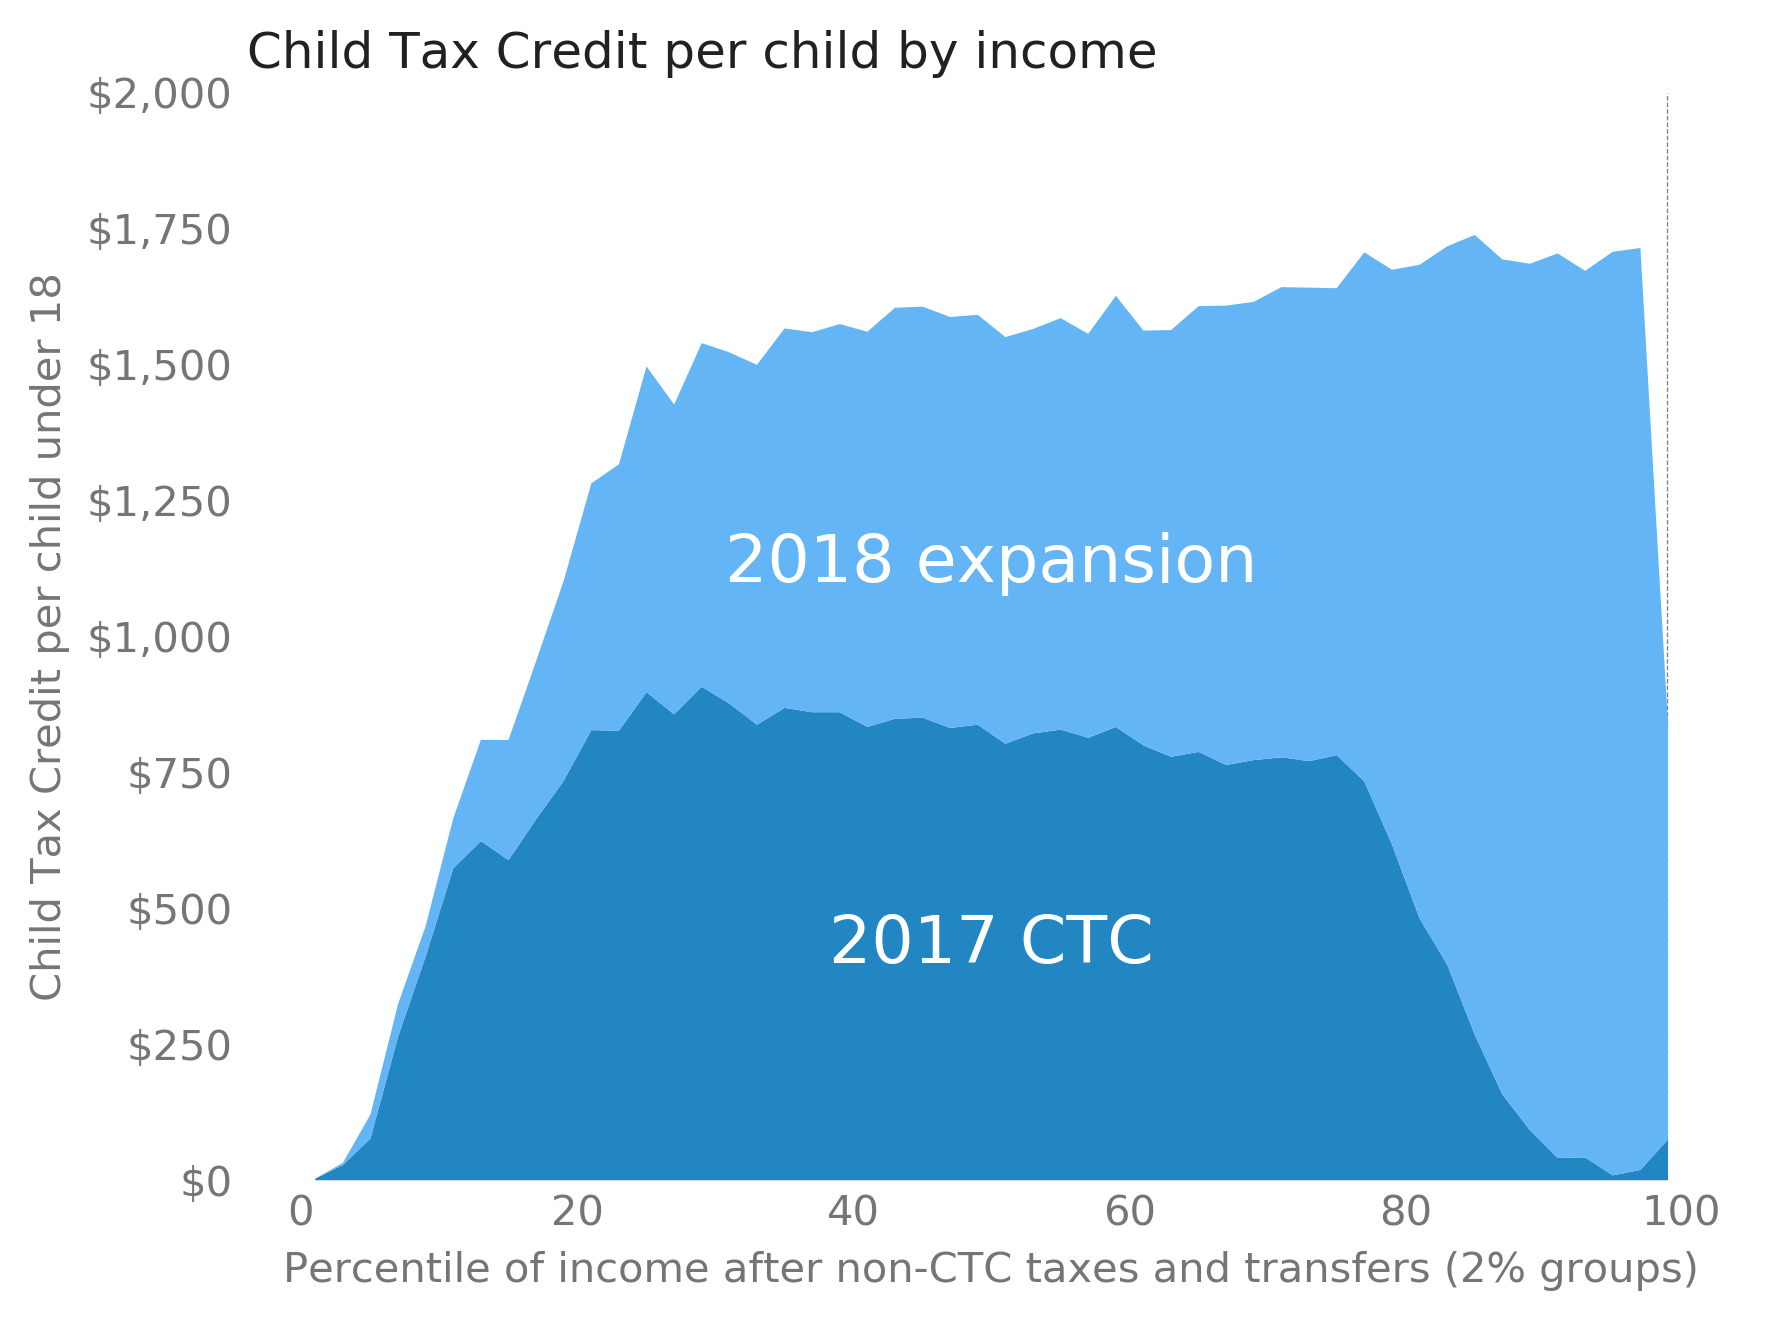

In [515]:
# Use colors from https://material.io/color/#!/?view.left=0&view.right=0&primary.color=64B5F6.
mpl.rcParams['figure.dpi']= 300
ax = twopct.plot(x='percentile', y=['ctc_per_nu18_2017', 'ctc_per_nu18_2018'],
    kind='area', color=['#2286c3', '#64b5f6'], linewidth=0) #, color=['#73e8ff', '#0086c3'])
ax.legend_.remove()
sns.despine(left=True, bottom=True)
ax.set(xlabel='Percentile of income after non-CTC taxes and transfers (2% groups)',
       ylabel='Child Tax Credit per child under 18',
       ylim=(0, 2000))
plt.axvline(x=99, c='gray', linestyle='dashed', linewidth=0.3, zorder=-1)
ax.text(50, 400, '2017 CTC', horizontalalignment='center', color='white', size=16)
ax.text(50, 1100, '2018 expansion', horizontalalignment='center', color='white', size=16)
ax.get_yaxis().set_major_formatter(
    mpl.ticker.FuncFormatter(lambda x, p: '$' + format(int(x), ',')))
plt.title('Child Tax Credit per child by income', loc='left')
# plt.figure(dpi=1200)
plt.show()

### Distributional impact

In [529]:
UBI_LABEL = '$1,450 (revenue-neutral)'
UBI_LABEL2 = '\$1,450\n(revenue-neutral)'
UBI_LABEL_ML = '\$1,450\n(revenue-\nneutral)',
TUBI_LABEL = '$2,000 (current maximum)'
TUBI_LABEL2 = '\$2,000\n(current maximum)'
TUBI_LABEL_ML = '\$2,000\n(current\nmaximum)'

UBI_COLOR = '#757575'
TUBI_COLOR = '#388e3c'

UBI_LABELS = [UBI_LABEL, TUBI_LABEL]
UBI_COLORS = [UBI_COLOR, TUBI_COLOR]
UBI_COLS = ['ubi_afti_pctchg', 'tubi_afti_pctchg']

YLAB = 'Change to income after taxes and transfers'

#### Impact by quartile

In [437]:
quart[UBI_COLS]

,ubi_afti_pctchg,tubi_afti_pctchg
aftertax_income_quartile,,
1,4.44,7.71
2,-0.34,1.58
3,-0.34,1.04
4,-0.18,0.42


Overall impact on upper 75%.

In [438]:
upper_75p = quart.loc[2:].sum()
add_ratios(upper_75p)
with pd.option_context('precision', 2):
    print upper_75p[UBI_COLS]

ubi_afti_pctchg    -0.25
tubi_afti_pctchg    0.74
dtype: float64


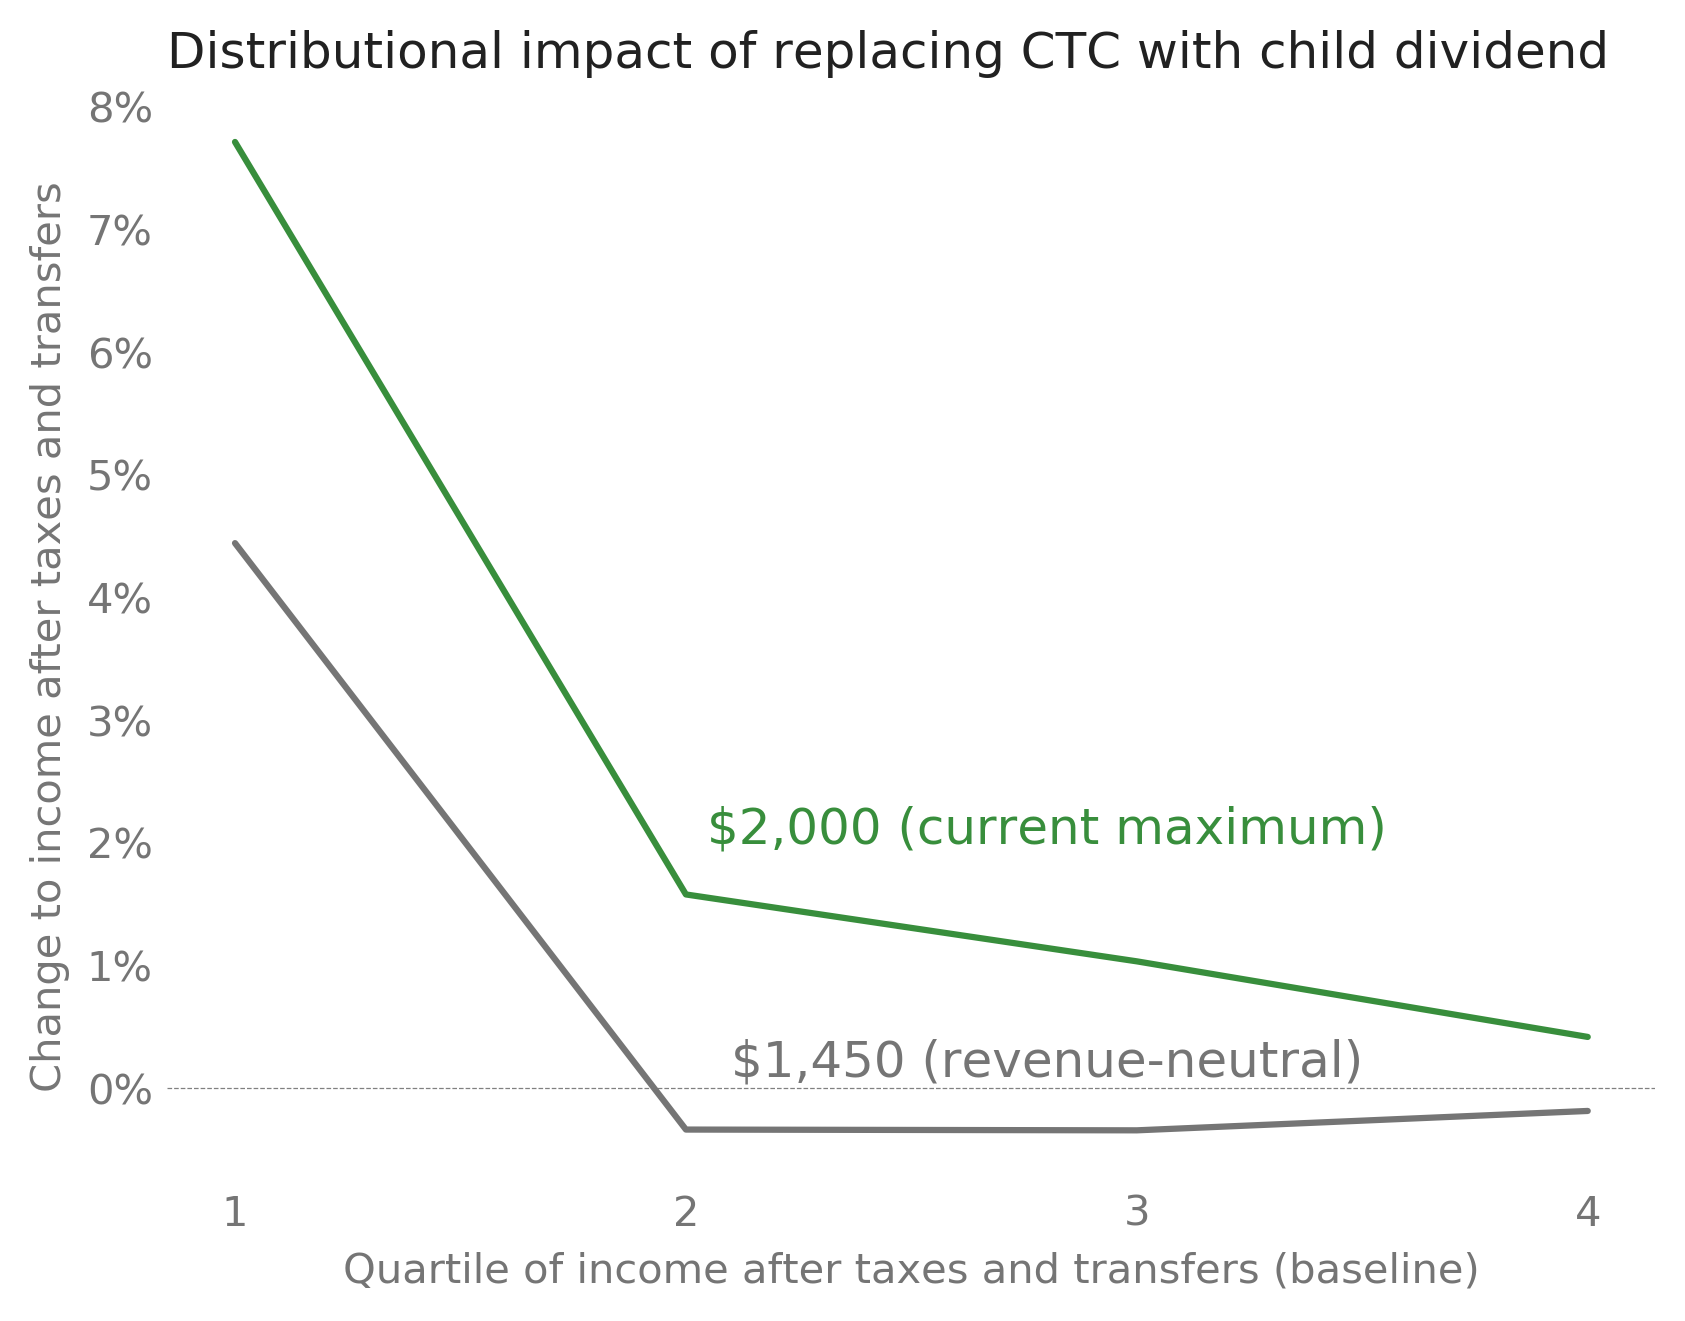

In [524]:
ax = quart.plot(y=UBI_COLS, color=UBI_COLORS)
ax.legend_.remove()
ax.text(2.8, 2, TUBI_LABEL, horizontalalignment='center', 
        color=TUBI_COLOR, size=12)
ax.text(2.8, 0.1, UBI_LABEL, horizontalalignment='center', 
        color=UBI_COLOR, size=12)
plt.axhline(y=0, c='gray', linestyle='dashed', linewidth=0.3, zorder=-1)
sns.despine(left=True, bottom=True)
ax.set(xlabel='Quartile of income after taxes and transfers (baseline)',
       ylabel=YLAB,
       xticks=[1, 2, 3, 4])
ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda y, _: '{:.0%}'.format(y / 100))) 
plt.title('Distributional impact of replacing CTC with child dividend', loc='left')
plt.show()

#### Bottom quartile

In 5% increments.

In [419]:
vent.loc[:5, ['ubi_afti_pctchg', 'tubi_afti_pctchg', 'keep_aftertax_income_per_person', 's006']]

,ubi_afti_pctchg,tubi_afti_pctchg,keep_aftertax_income_per_person,s006
aftertax_income_ventile,,,,
1,84.83,116.51,918.13,2.69e+06
2,10.74,15.87,4828.29,2.75e+06
3,3.85,6.74,8190.92,2.75e+06
4,2.19,4.65,9993.62,2.75e+06
5,0.53,2.64,11779.27,2.75e+06


\$918 per person per year is roughly $2.50 per day. 2.7M households in each ventile.

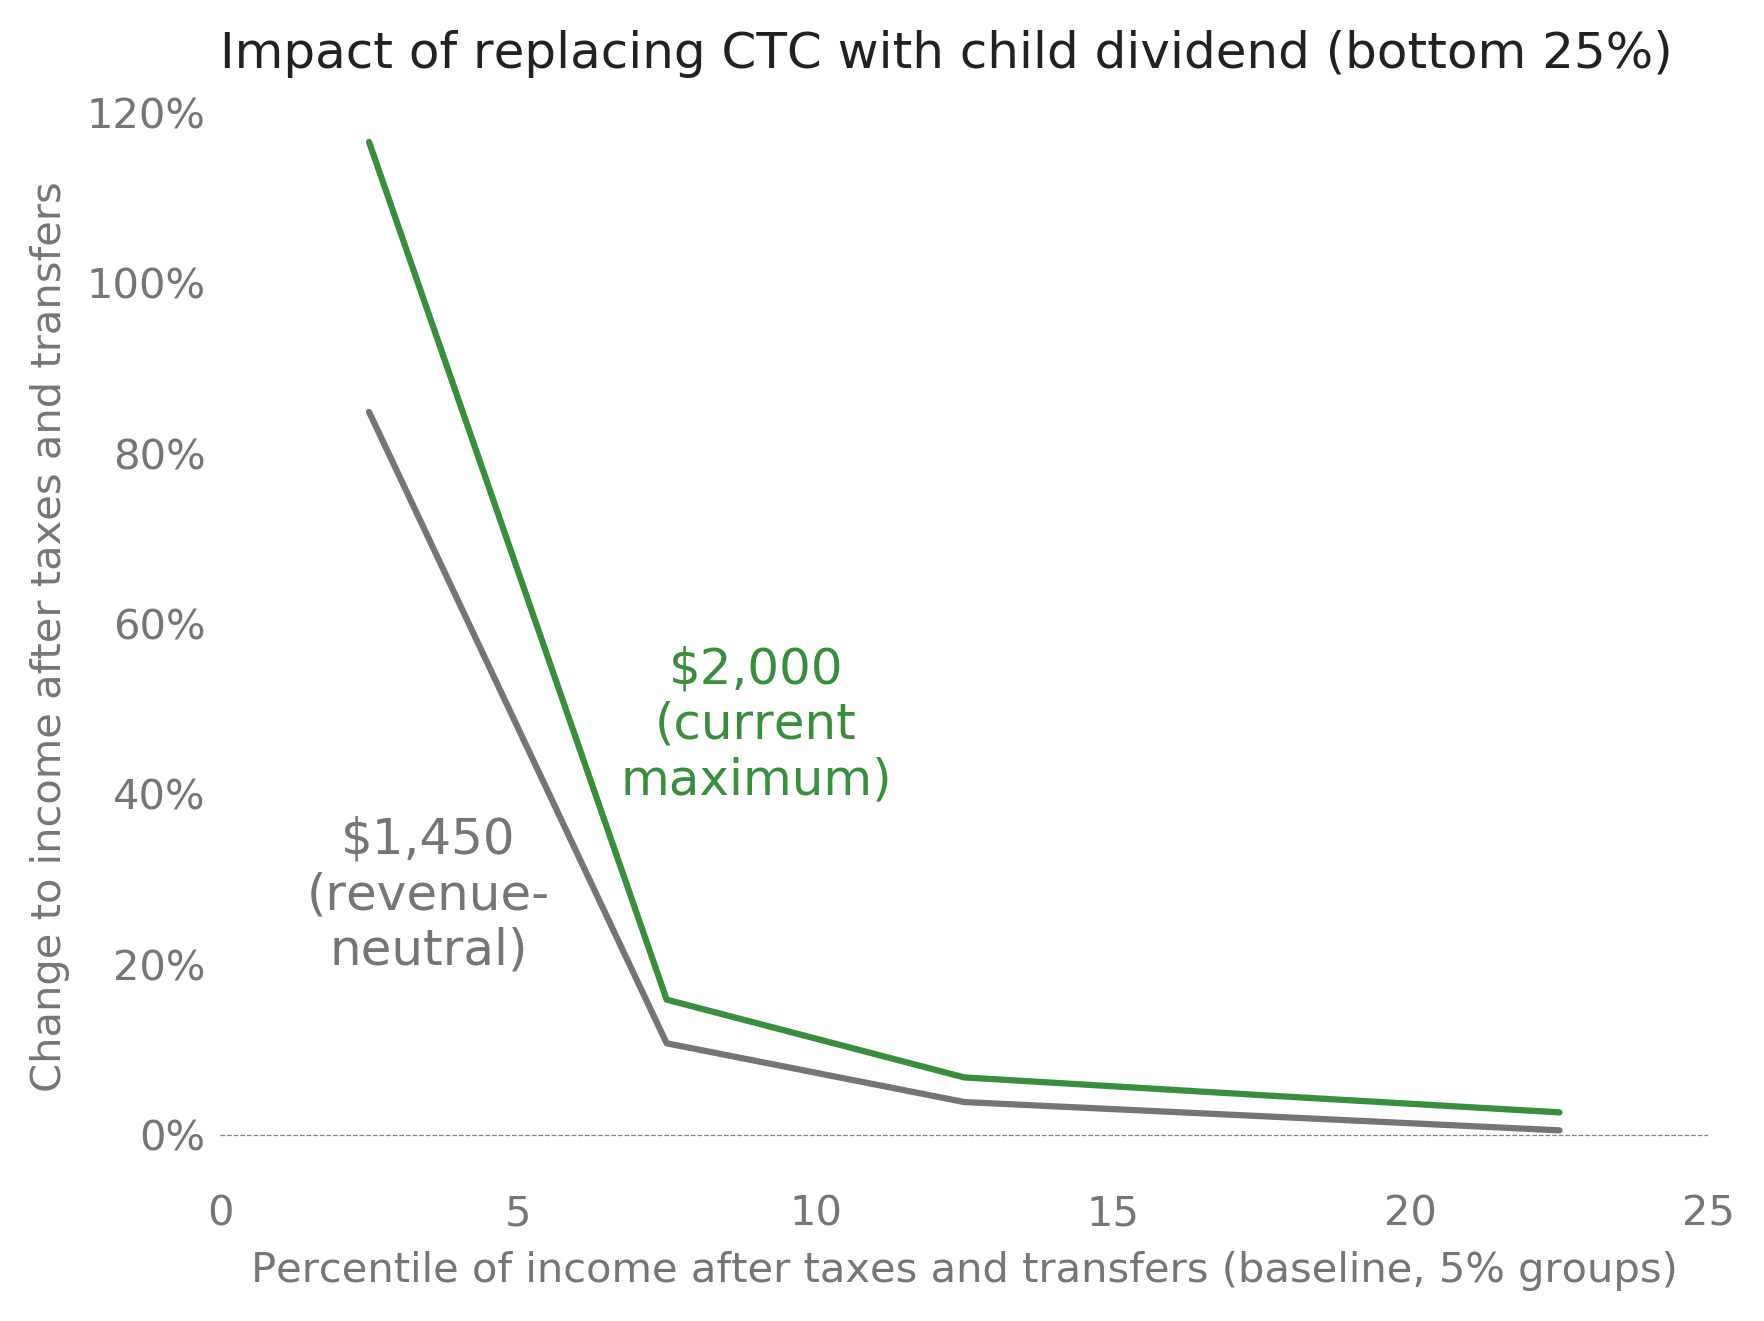

In [536]:
ax = vent[:5].plot(x='percentile', y=UBI_COLS, color=UBI_COLORS)
ax.legend_.remove()
ax.text(9, 40, '\$2,000\n(current\nmaximum)', horizontalalignment='center', 
        color=TUBI_COLOR, size=12)
ax.text(3.5, 20, '\$1,450\n(revenue-\nneutral)', horizontalalignment='center',
        multialignment='center', color=UBI_COLOR, size=12)
plt.axhline(y=0, c='gray', linestyle='dashed', linewidth=0.3, zorder=-1)
sns.despine(left=True, bottom=True)
ax.set(xlabel='Percentile of income after taxes and transfers (baseline, 5% groups)',
       ylabel=YLAB,
       xlim=[0, 25])
ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda y, _: '{:.0%}'.format(y / 100))) 
plt.title('Impact of replacing CTC with child dividend (bottom 25%)', loc='left')
plt.show()

#### Impact on upper 75%.

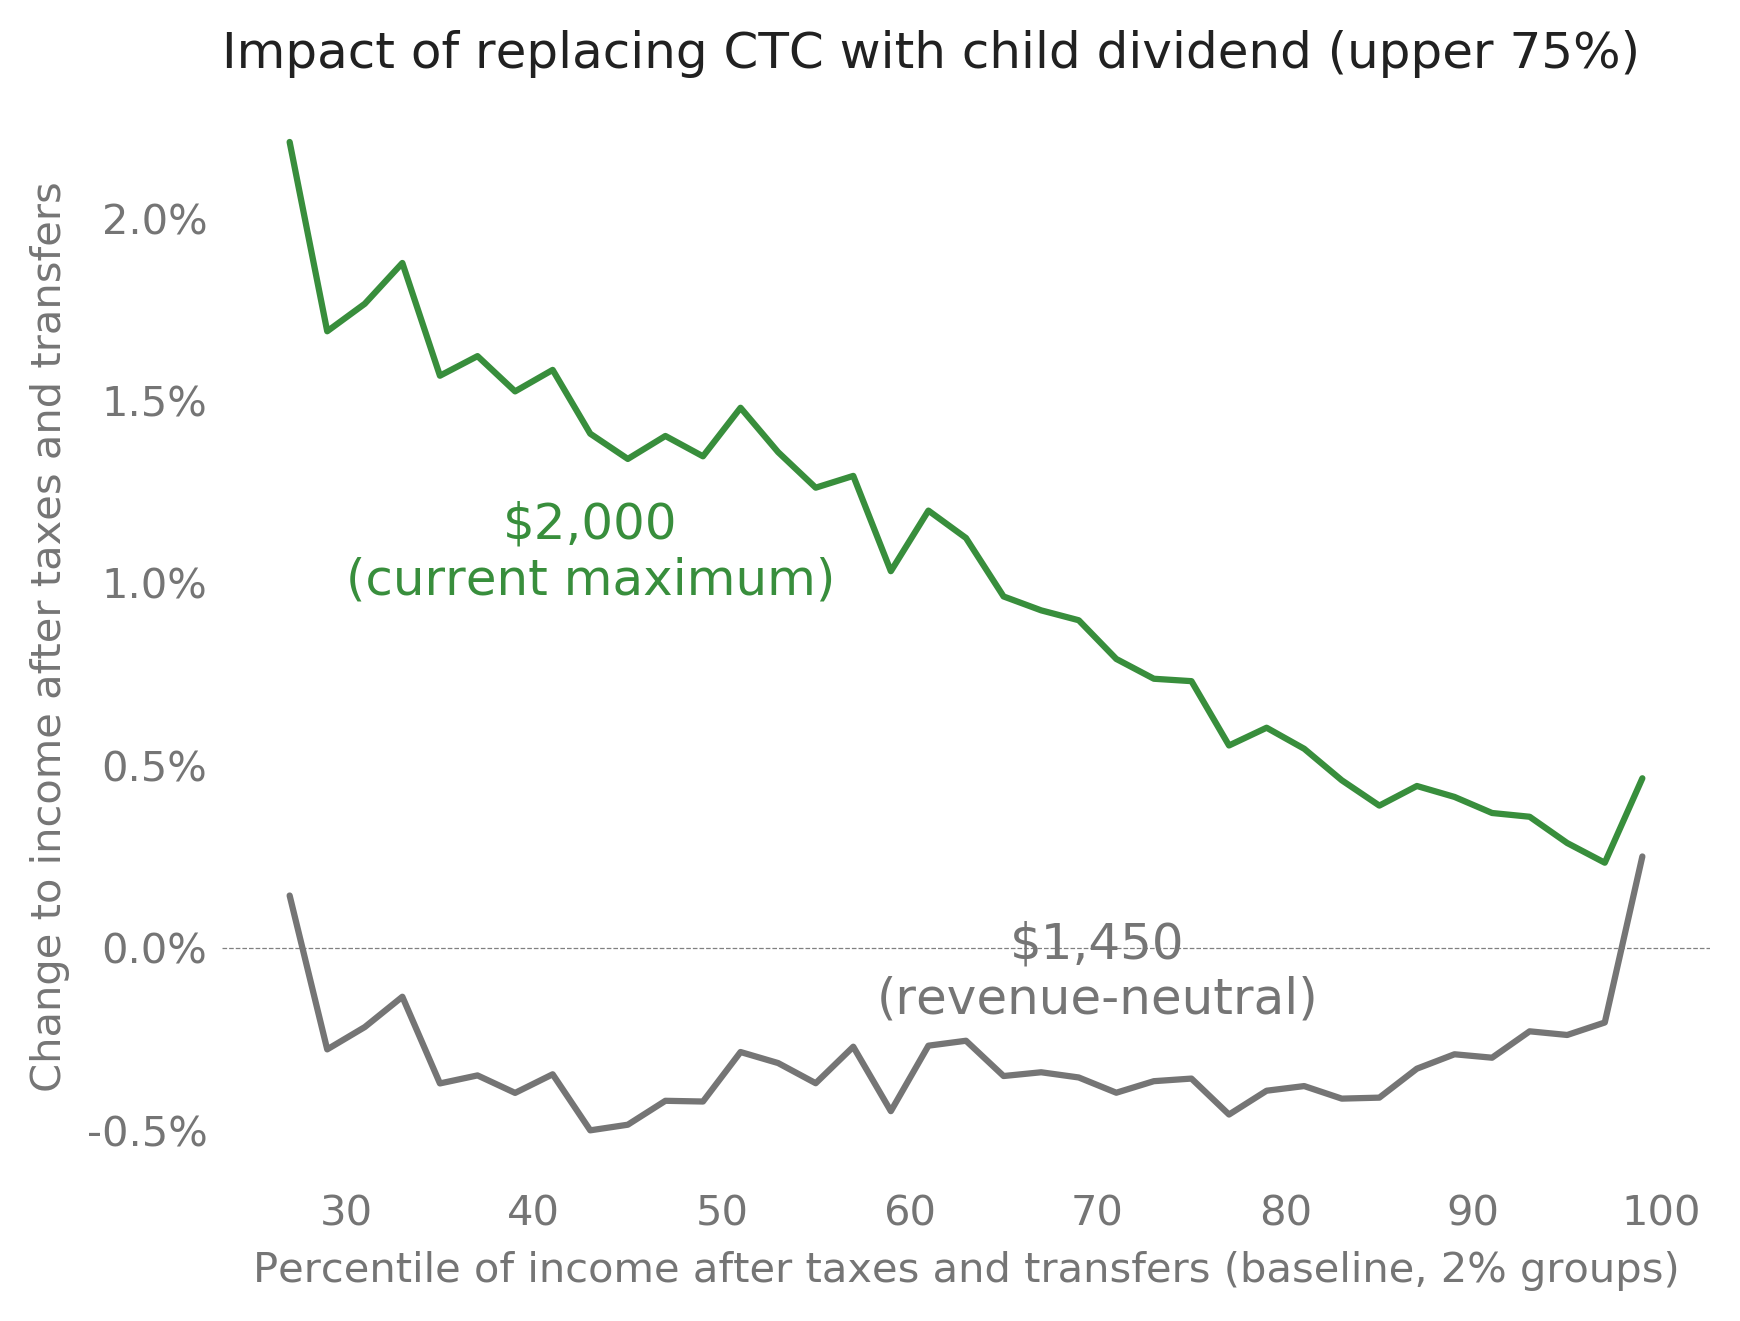

In [550]:
ax = twopct[13:].plot(x='percentile', y=UBI_COLS, color=UBI_COLORS)
# ax.legend(UBI_LABELS)  # If new data.
ax.legend_.remove()
ax.text(43, 0.97, TUBI_LABEL2, horizontalalignment='center', 
        color=TUBI_COLOR, size=12)
ax.text(70, -0.18, UBI_LABEL2, horizontalalignment='center',
        color=UBI_COLOR, size=12)
plt.axhline(y=0, c='gray', linestyle='dashed', linewidth=0.3, zorder=-1)
sns.despine(left=True, bottom=True)
ax.set(xlabel='Percentile of income after taxes and transfers (baseline, 2% groups)',
       ylabel=YLAB)
ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda y, _: '{:.1%}'.format(y / 100))) 
plt.title('Impact of replacing CTC with child dividend (upper 75%)', loc='left')
plt.show()

Top 1% does better off. 2nd percentile is basically flat.

In [422]:
pct.loc[98:, ['ubi_afti_pctchg', 'tubi_afti_pctchg']]

,ubi_afti_pctchg,tubi_afti_pctchg
aftertax_income_percentile,,
98,-0.18,0.22
99,0.02,0.35
100,0.36,0.52


In [421]:
twopct.loc[50, ['ubi_afti_pctchg', 'tubi_afti_pctchg']]

ubi_afti_pctchg     0.25
tubi_afti_pctchg    0.46
Name: 50, dtype: float64

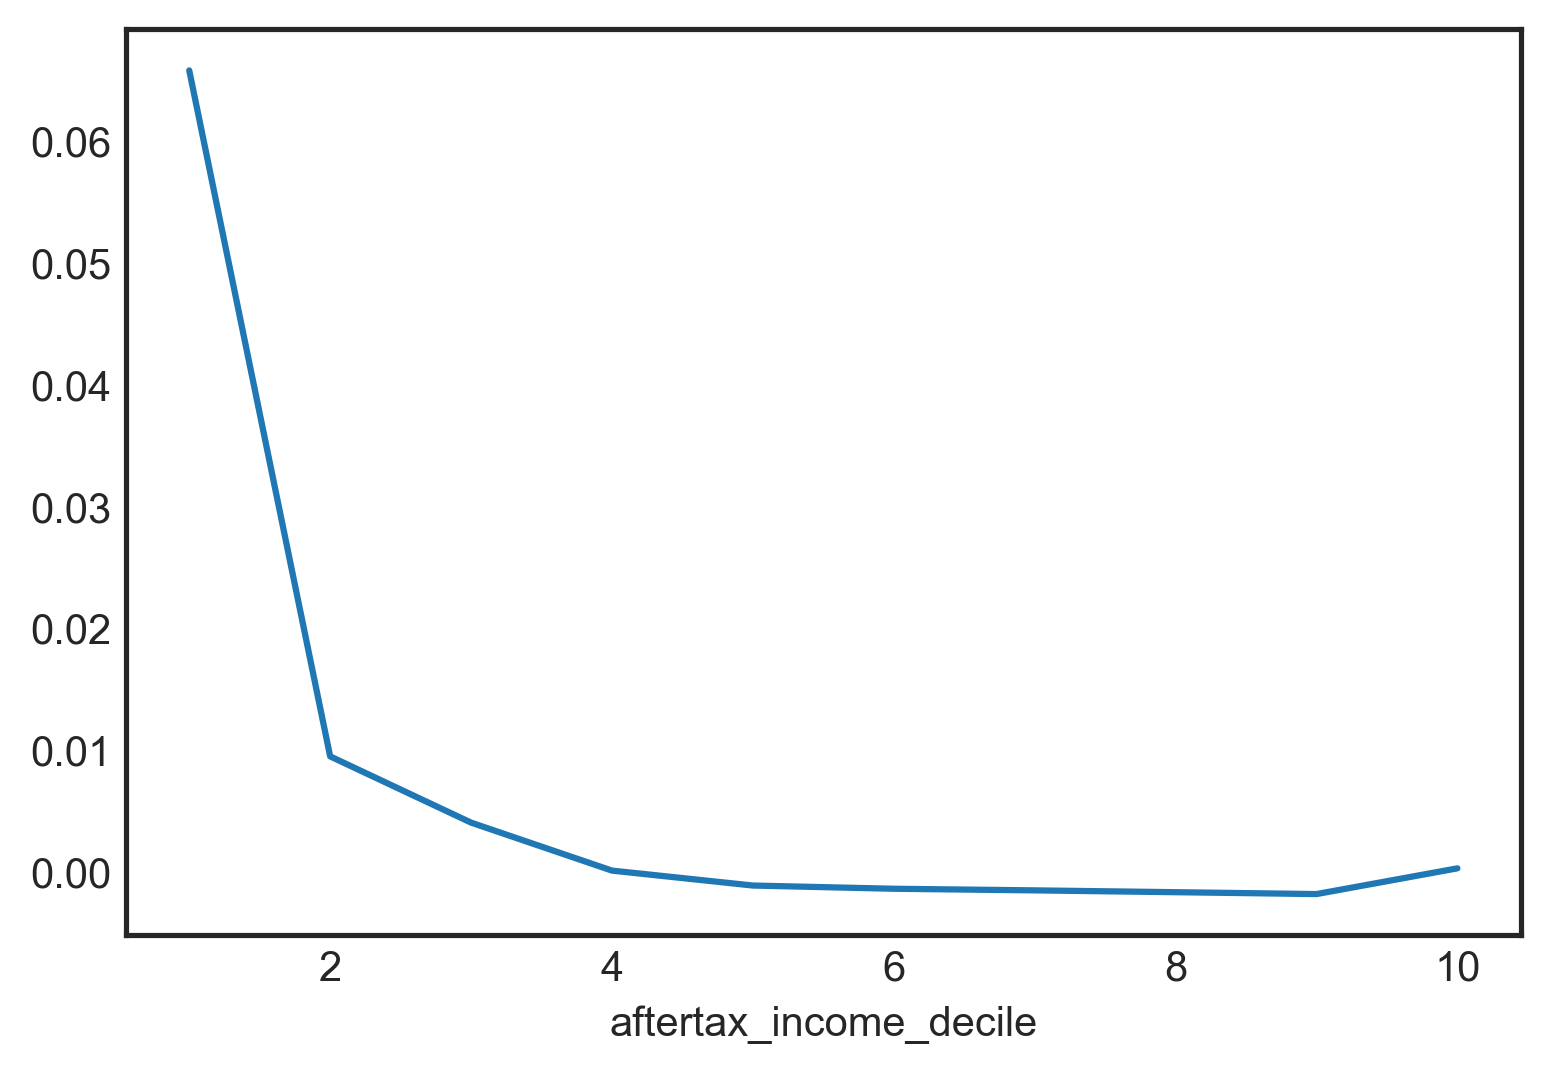

In [88]:
dec['ubi_afti_pctchg'].plot()
plt.show()

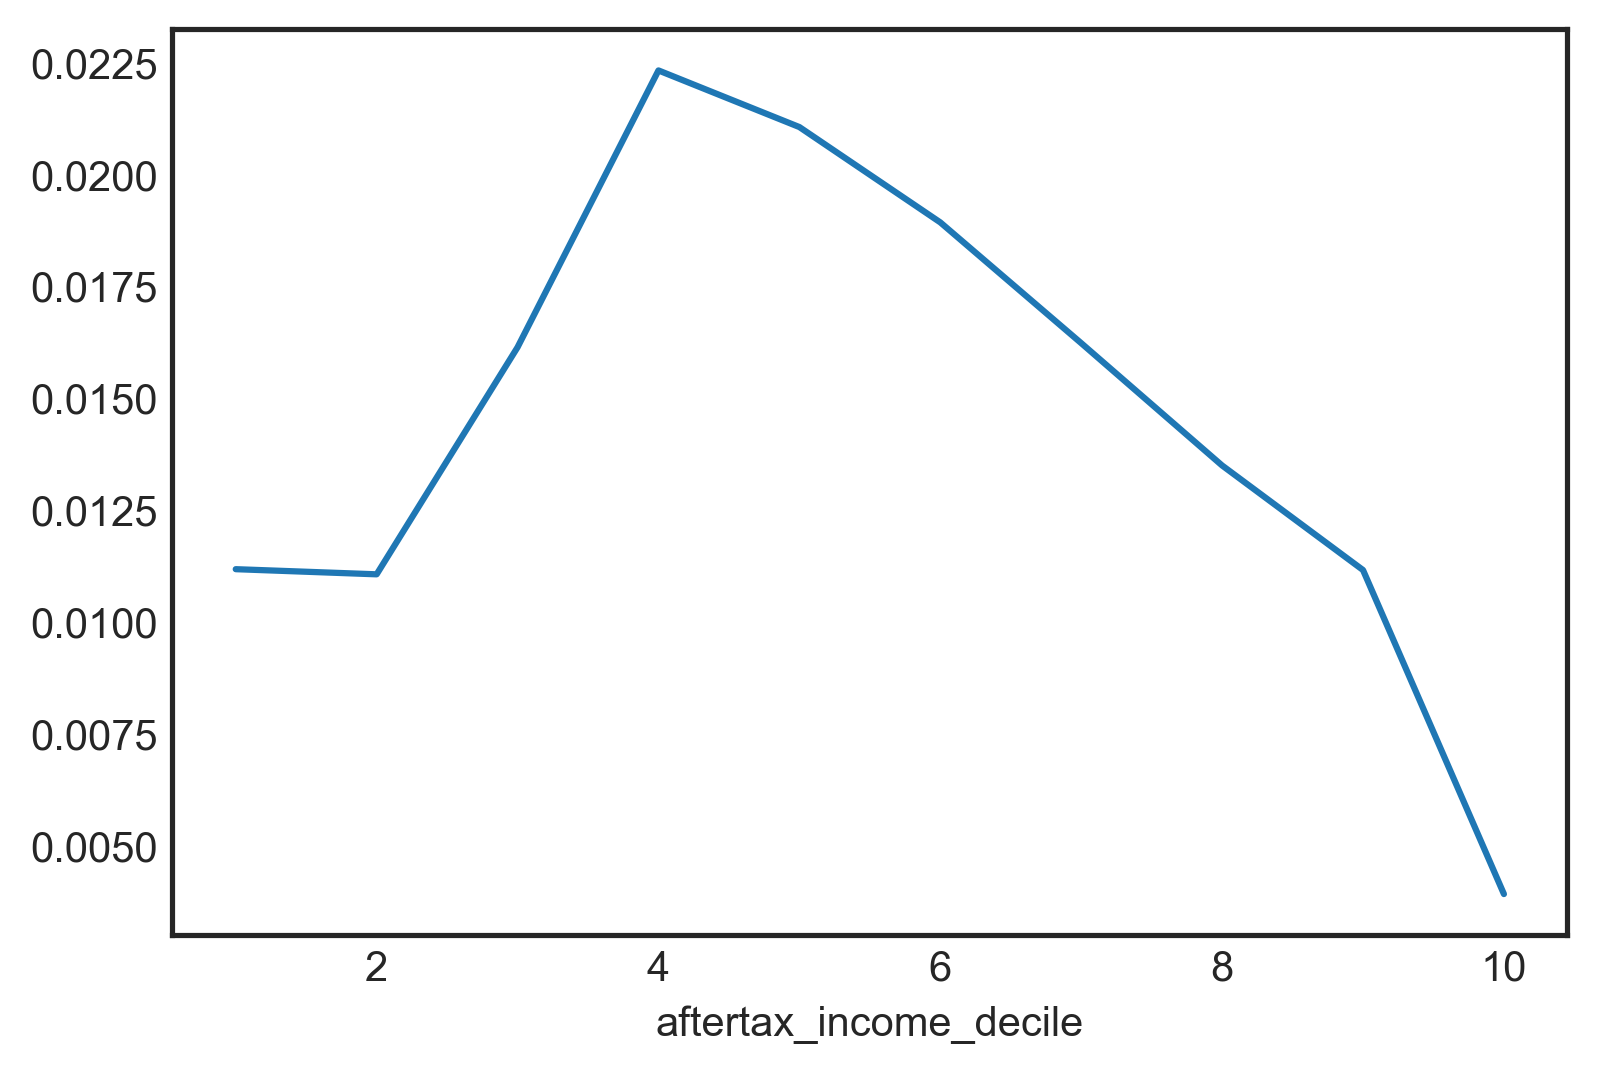

In [121]:
(-dec['repeal_afti_pctchg']).plot()
plt.show()

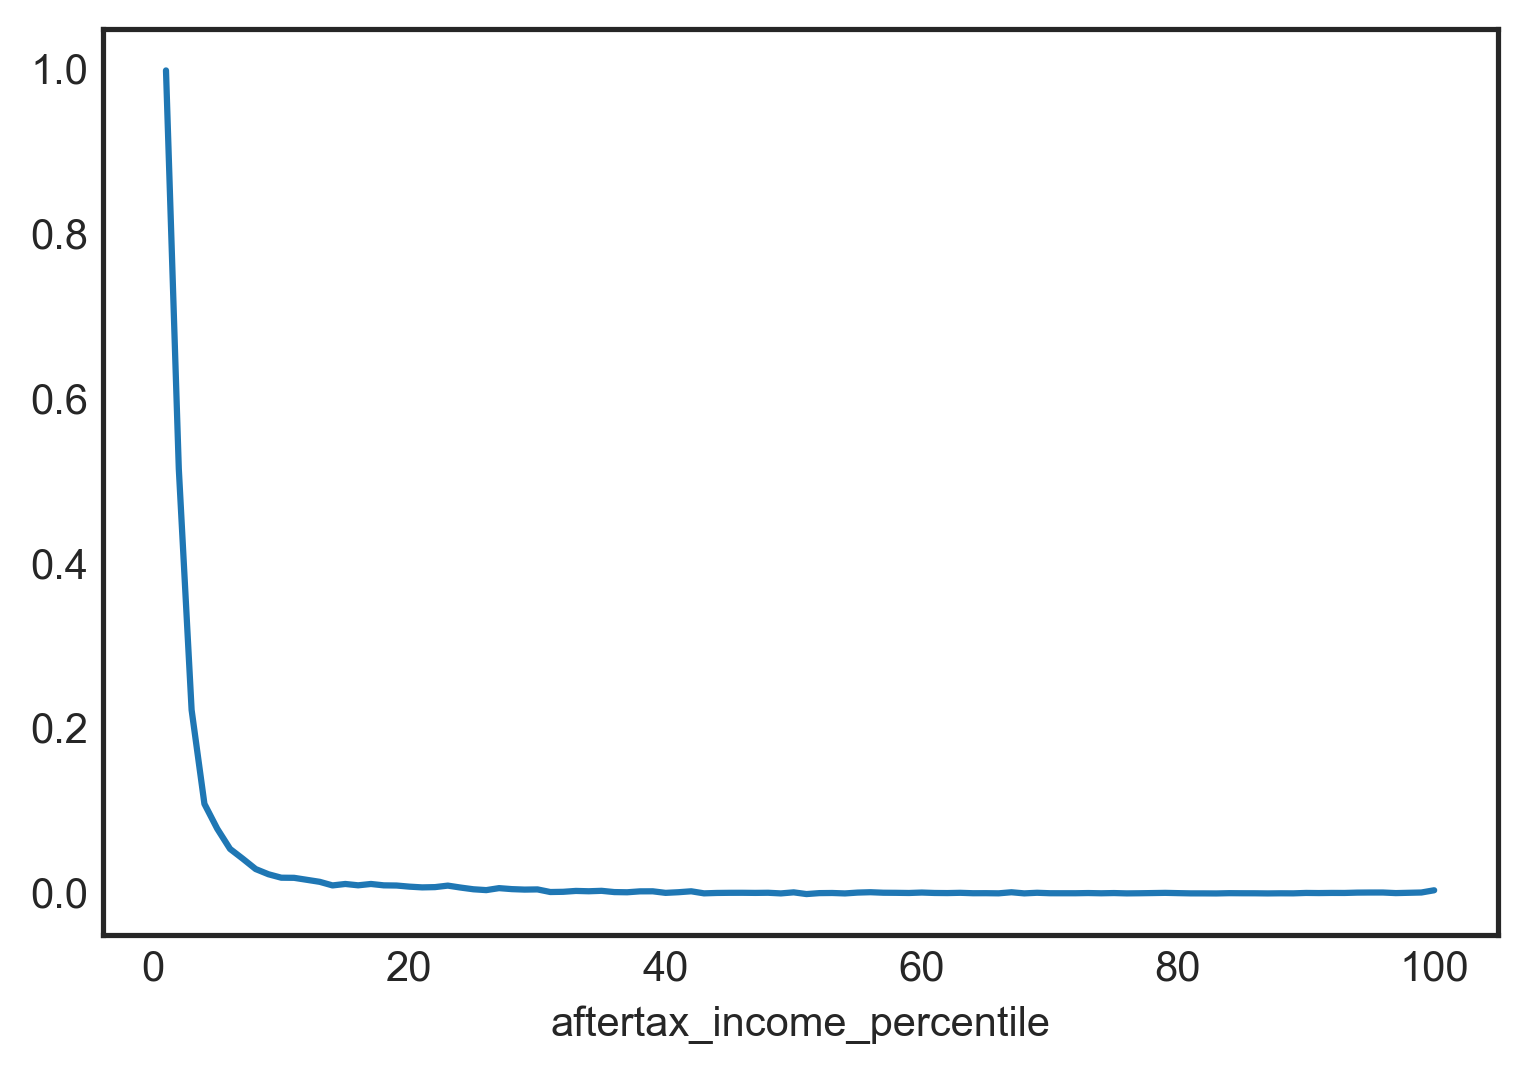

In [89]:
pct['ubi_afti_pctchg'].plot()
plt.show()

In [90]:
pct['ubi_afti_pctchg']

aftertax_income_percentile
1      0.997135
2      0.513500
3      0.220740
4      0.106696
5      0.076551
6      0.052030
7      0.040044
8      0.027583
9      0.021248
10     0.017078
11     0.016923
12     0.014500
13     0.012069
14     0.007707
15     0.009464
16     0.007828
17     0.009463
18     0.007793
19     0.007583
20     0.006218
21     0.005318
22     0.005642
23     0.007474
24     0.005099
25     0.003017
26     0.002001
27     0.004411
28     0.003208
29     0.002630
30     0.002863
         ...   
71    -0.001805
72    -0.001798
73    -0.001549
74    -0.001841
75    -0.001570
76    -0.001960
77    -0.001807
78    -0.001577
79    -0.001322
80    -0.001658
81    -0.001947
82    -0.001964
83    -0.002039
84    -0.001712
85    -0.001807
86    -0.001844
87    -0.002003
88    -0.001850
89    -0.001925
90    -0.001416
91    -0.001576
92    -0.001403
93    -0.001445
94    -0.001031
95    -0.000925
96    -0.000909
97    -0.001614
98    -0.001244
99    -0.000890
100    0.0018

In [269]:
pct['ubi_afti_chg_per_nu18'].plot()
plt.show()

KeyError: 'ubi_afti_chg_per_nu18'

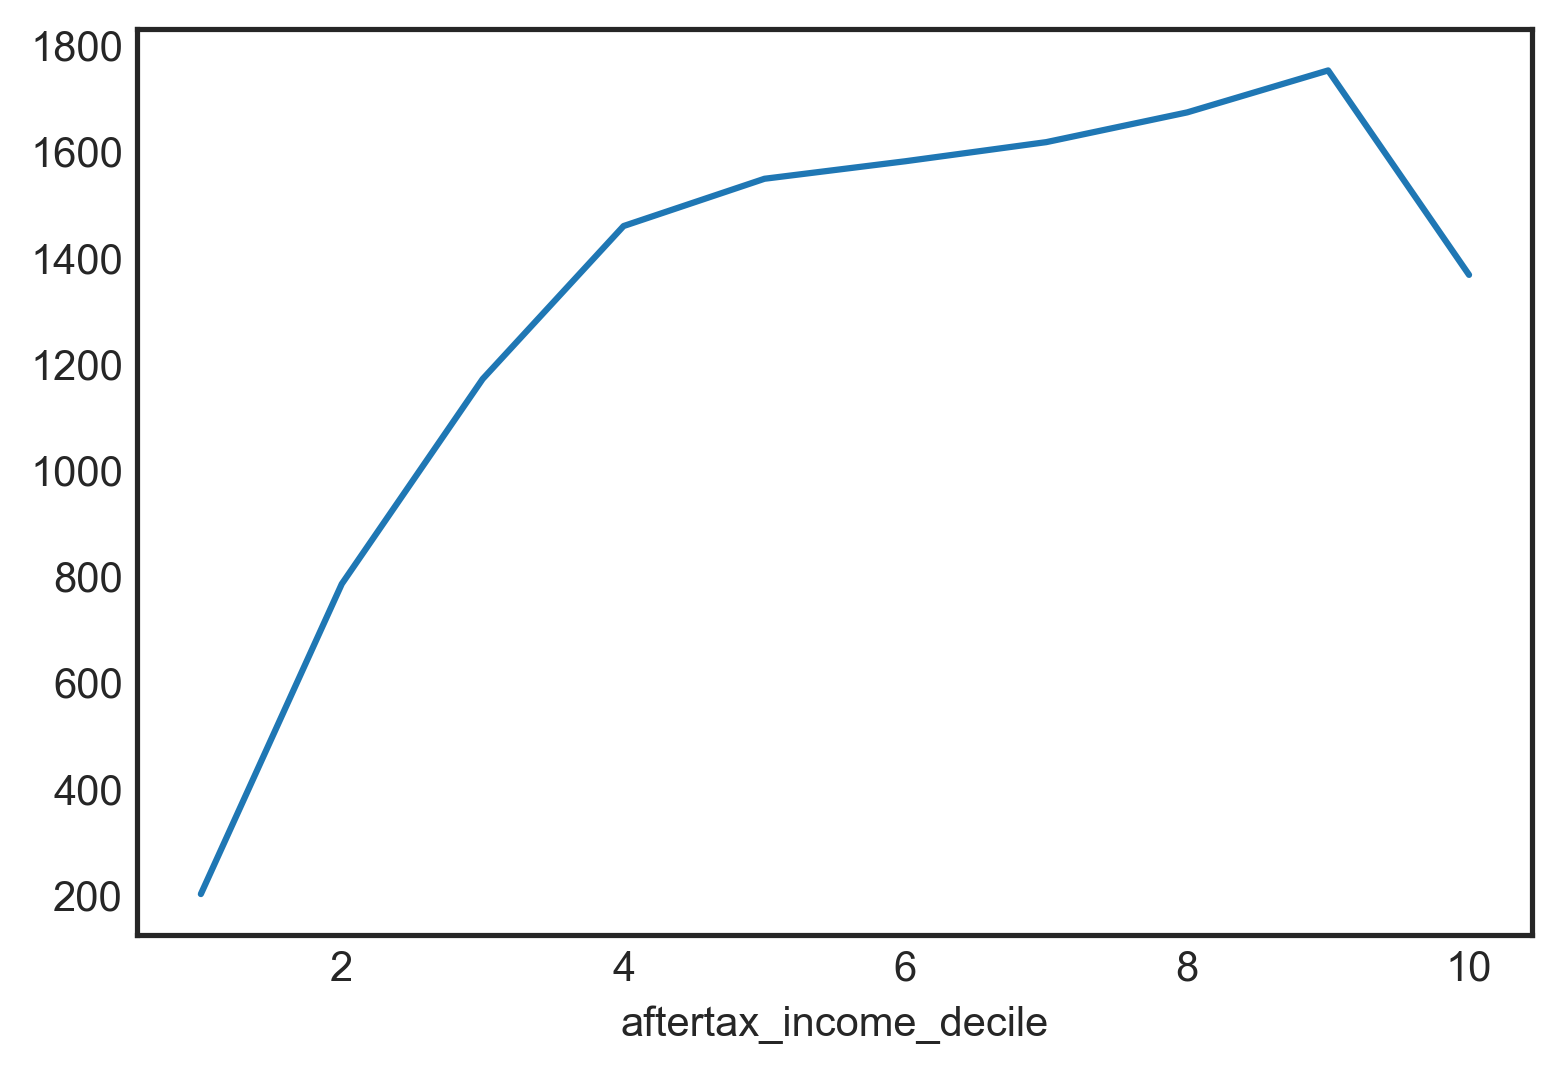

In [78]:
dec['ctc_per_nu18'].plot()
plt.show()

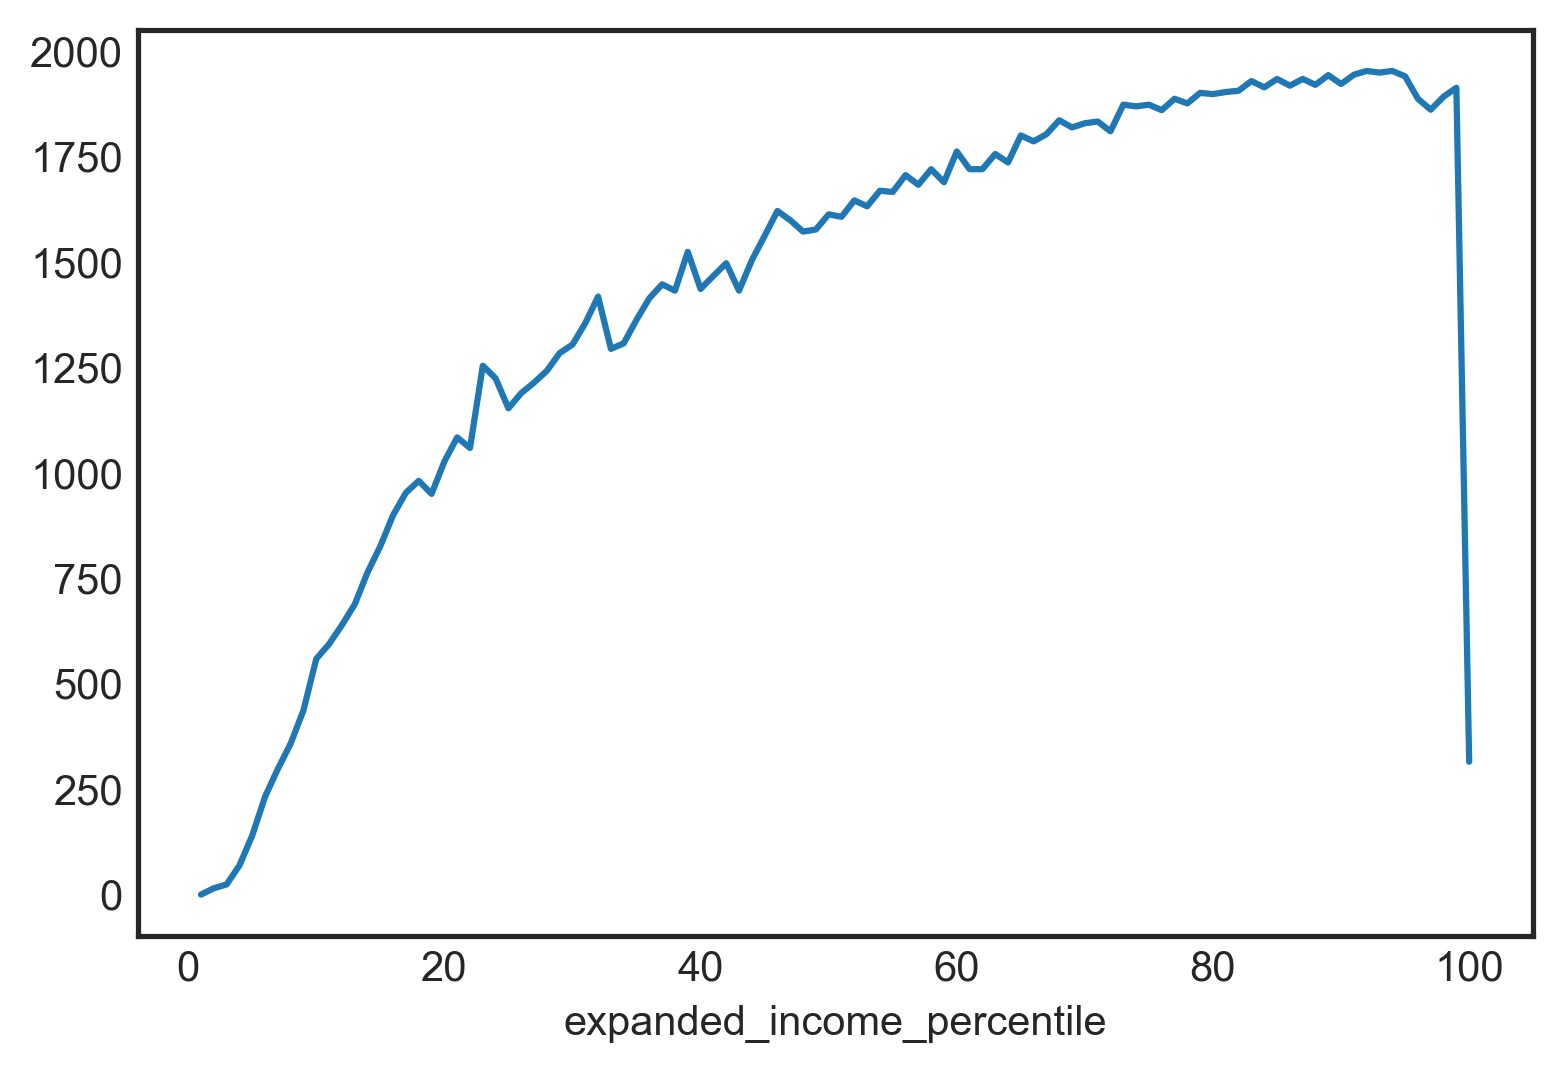

In [133]:
pct_e['ctc_per_n24'].plot()
plt.show()

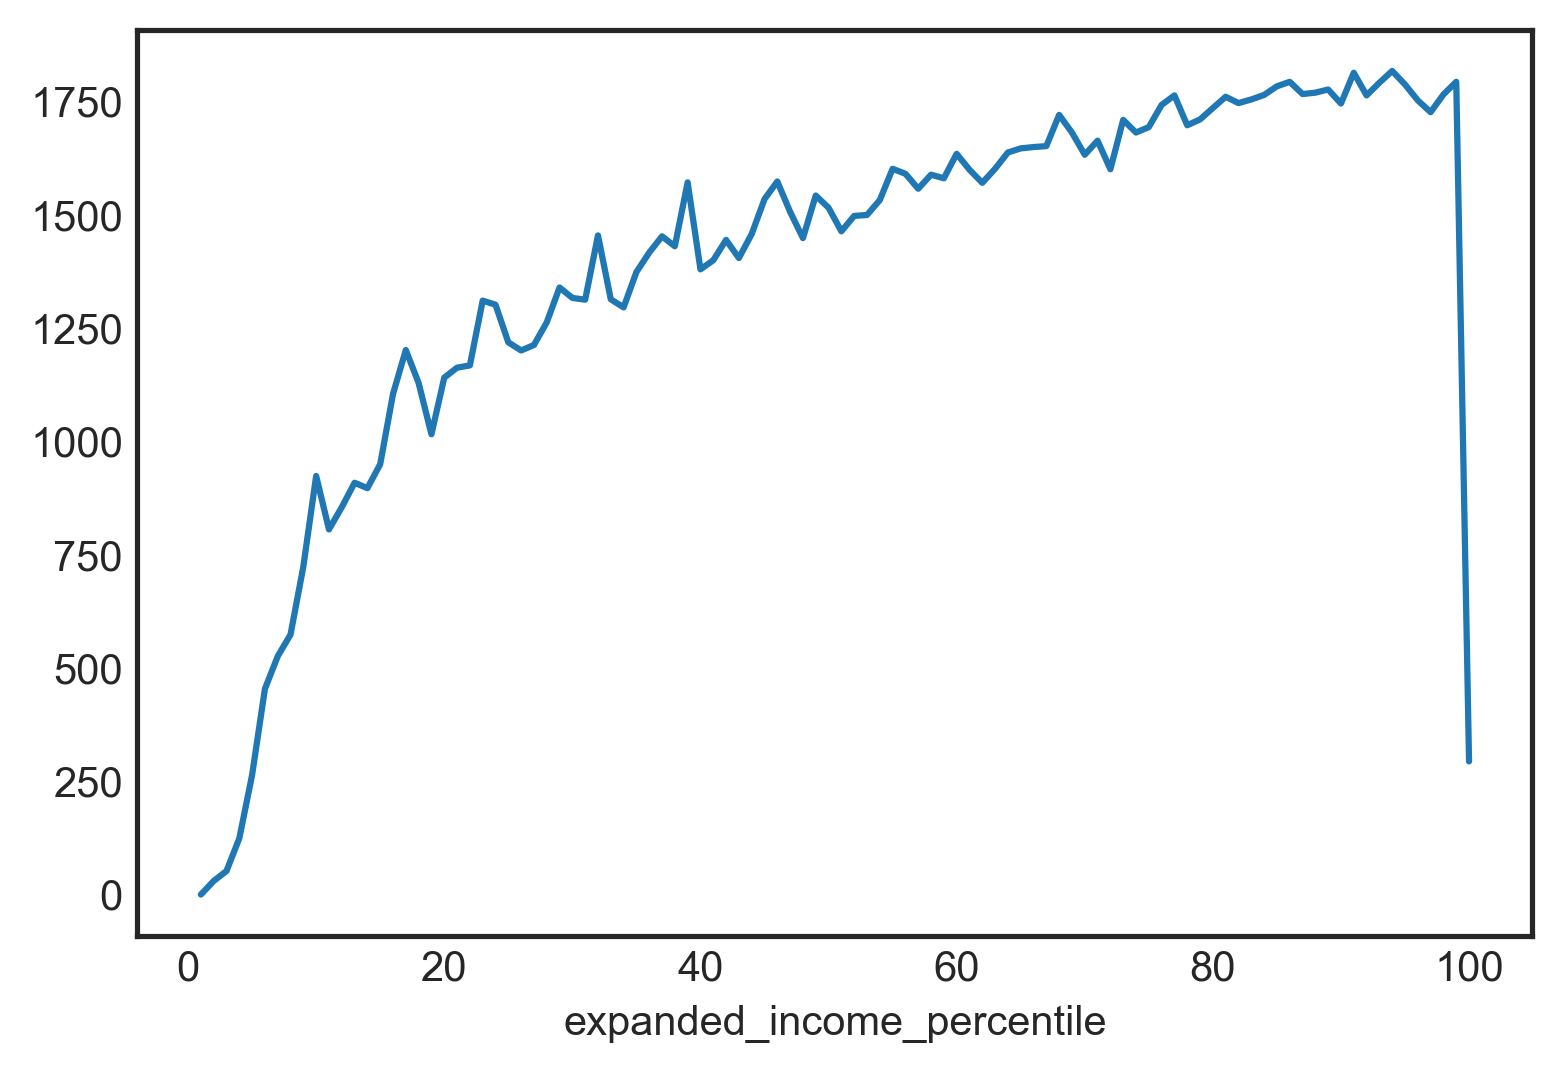

In [134]:
pct_e['ctc_per_nu18'].plot()
plt.show()

In [80]:
pct['ctc_per_nu18']

aftertax_income_percentile
1         1.0
2        19.0
3        44.0
4       122.0
5       137.0
6       268.0
7       376.0
8       416.0
9       478.0
10      543.0
11      541.0
12      574.0
13      711.0
14      861.0
15      769.0
16      874.0
17      785.0
18      865.0
19      850.0
20      973.0
21     1058.0
22     1029.0
23      960.0
24     1078.0
25     1220.0
26     1304.0
27     1140.0
28     1236.0
29     1289.0
30     1277.0
        ...  
71     1675.0
72     1673.0
73     1640.0
74     1671.0
75     1652.0
76     1700.0
77     1699.0
78     1683.0
79     1646.0
80     1685.0
81     1744.0
82     1760.0
83     1759.0
84     1714.0
85     1738.0
86     1751.0
87     1768.0
88     1777.0
89     1784.0
90     1721.0
91     1769.0
92     1760.0
93     1779.0
94     1707.0
95     1711.0
96     1664.0
97     1771.0
98     1770.0
99     1730.0
100     203.0
Name: ctc_per_nu18, Length: 100, dtype: float64

## Appendix

Tax units with greatest change to after-tax income from the UBI model.

In [249]:
scenario18[(scenario18['rev_neutral_ubi_aftertax_income_b'] >= 0) &
           (scenario18['keep_aftertax_income_b'] >= 0) &
           (scenario18['ubi_afti_chg'] < np.inf)].sort_values('ubi_afti_chg').tail()

,id,keep_aftertax_income_b,repeal_aftertax_income_b,rev_neutral_ubi_aftertax_income_b,top_ubi_aftertax_income_b,nu18,n24,s006,nu18_m,n24_m,...,aftertax_income_quintile,expanded_income_percentile,expanded_income_decile,expanded_income_quintile,repeal_afti_chg,repeal_afti_pctchg,ubi_afti_chg,ubi_afti_pctchg,ctc_per_n24,ctc_per_nu18
416420,208210,9.5e-02,9.5e-02,1.1e-01,1.1e-01,5.0,3.0,1960.3,9.8e-03,5.9e-03,...,3,49,5,3,0.0e+00,0.0e+00,1.4e-02,0.1,0.0,0.0
474510,237255,4.6e-02,4.6e-02,6.0e-02,6.5e-02,5.0,0.0,1964.3,9.8e-03,0.0e+00,...,2,25,3,2,0.0e+00,0.0e+00,1.4e-02,0.2,NaN,0.0
55834,27917,1.1e-01,1.1e-01,1.3e-01,1.3e-01,10.0,3.0,1195.8,1.2e-02,3.6e-03,...,4,72,8,4,-2.1e-03,-1.9e-02,1.5e-02,0.1,576.0,0.0
519080,259540,0.0e+00,0.0e+00,1.7e-02,2.3e-02,4.0,3.0,2833.1,1.1e-02,8.5e-03,...,1,1,1,1,0.0e+00,NaN,1.7e-02,1.0,0.0,0.0
646484,323242,9.8e-02,9.8e-02,1.2e-01,1.3e-01,9.0,0.0,1651.6,1.5e-02,0.0e+00,...,4,57,6,3,0.0e+00,0.0e+00,2.2e-02,0.2,NaN,0.0


### Differences between `nu18` and `n24`

What explains the difference by decile?

In [20]:
keep_cur = scenarios[(~scenarios['use_2017_law']) & 
                     (scenarios['ctc_treatment'] == 'keep')]
print ('Total children under 18: ' +
       '{:0.1f}M'.format((keep_cur['nu18_m'].sum())))
print ('Total children eligible for CTC: ' +
       '{:0.1f}M'.format((keep_cur['n24_m'].sum())))

Total children under 18: 82.0M
Total children eligible for CTC: 81.9M


How many households have nu18 > n24? n24 > nu18?

In [21]:
keep_cur.pivot_table(index='n24', columns='nu18', values='s006', aggfunc=sum)

nu18,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0
n24,,,,,,,,,,,,,
0.0,1.1e+08,5.8e+06,5.5e+05,2.1e+05,6.9e+04,18471.4,5404.8,2750.3,50.6,3008.3,NaN,NaN,NaN
1.0,4.8e+06,1.7e+07,1.8e+06,8.7e+04,1.6e+04,3154.0,218.9,NaN,NaN,NaN,NaN,NaN,NaN
2.0,2.2e+06,8.5e+05,1.3e+07,9.3e+05,4.7e+04,7316.6,1759.9,486.0,NaN,NaN,NaN,NaN,NaN
3.0,1.0e+06,4.8e+05,2.9e+04,4.6e+06,1.6e+06,459044.9,135175.9,47640.0,15654.6,5527.2,4263.2,119.0,147.7


In [22]:
keep_cur[keep_cur['nu18'] > keep_cur['n24']]['s006'].sum() / 1e6

11.757627969999998

In [23]:
keep_cur[keep_cur['n24'] > keep_cur['nu18']]['s006'].sum() / 1e6

9.3909378300000004

#### `n18 / n24` by percentile

In [24]:
pct_e_cur = keep_cur.groupby('expanded_income_percentile').sum()
pct_e_cur['n24_per_nu18'] = pct_e_cur['n24_m'] / pct_e_cur['nu18_m']

In [25]:
pct_e_cur['n24_per_nu18'].head(10)

expanded_income_percentile
0    0.8
1    0.8
2    1.9
3    2.1
4    1.8
5    1.9
6    1.9
7    1.7
8    1.6
9    1.7
Name: n24_per_nu18, dtype: float64

In [26]:
dec_e_cur = keep_cur.groupby('expanded_income_decile').sum()
dec_e_cur['n24_per_nu18'] = dec_e_cur['n24_m'] / dec_e_cur['nu18_m']

In [27]:
dec_e_cur[['n24_m', 'nu18_m', 'n24_per_nu18']]

,n24_m,nu18_m,n24_per_nu18
expanded_income_decile,,,
0,8.2e-02,9.8e-02,0.8
1,7.9e+00,4.7e+00,1.7
2,5.7e+00,4.5e+00,1.3
3,6.0e+00,5.7e+00,1.1
4,6.6e+00,6.5e+00,1.0
5,7.5e+00,7.9e+00,1.0
6,8.1e+00,8.7e+00,0.9
7,8.5e+00,9.4e+00,0.9
8,9.4e+00,1.0e+01,0.9


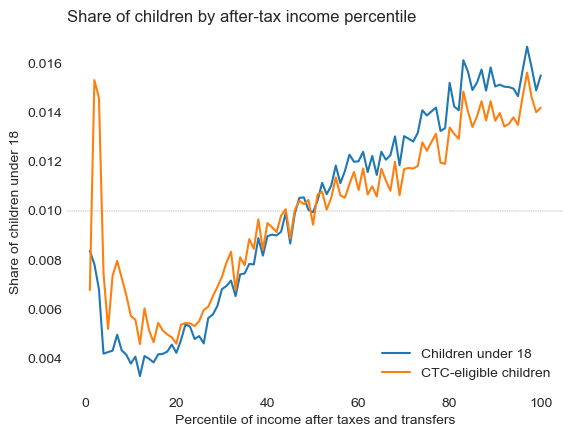

In [63]:
f, ax = plt.subplots()
(pct['nu18_m'] / pct['nu18_m'].sum()).plot(label='Children under 18')
(pct['n24_m'] / pct['n24_m'].sum()).plot(label='CTC-eligible children')
sns.despine(left=True, bottom=True)
plt.legend()
ax.set(xlabel='Percentile of income after taxes and transfers',
       ylabel='Share of children under 18')
plt.axhline(y=0.01, c='gray', linestyle='dashed', linewidth=0.3, zorder=-1)
plt.title('Share of children by after-tax income percentile', loc='left')
plt.show()

Ratio between the two.

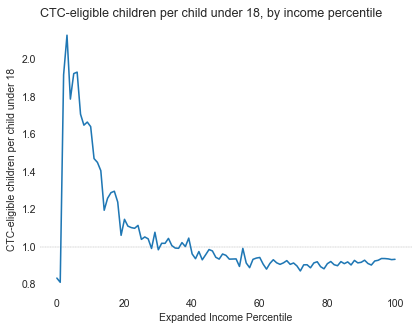

In [78]:
f, ax = plt.subplots()

pct_e_cur['n24_per_nu18'].plot()

sns.despine(left=True, bottom=True)

ax.set(xlabel='Expanded Income Percentile',
       ylabel='CTC-eligible children per child under 18')

plt.title('CTC-eligible children per child under 18, by income percentile', loc='left')

plt.axhline(y=1, c='gray', linestyle='dashed', linewidth=0.3, zorder=-1)

plt.show()

## Utility functions

In [257]:
# Function that takes a set of dimensions and metrics, and 
# creates a summary table where metrics are properly weighted.

### Extra charts

#### CTC per child by ventile

Percentile shows the drop at top two percentiles more clearly.

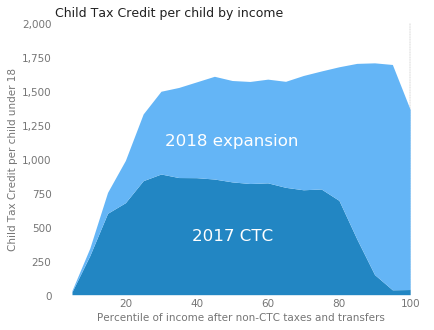

In [382]:
# Use colors from https://material.io/color/#!/?view.left=0&view.right=0&primary.color=64B5F6.
ax = vent.plot(x='percentile', y=['ctc_per_nu18_2017', 'ctc_per_nu18_2018'],
    kind='area', color=['#2286c3', '#64b5f6'], linewidth=0)
ax.legend_.remove()
sns.despine(left=True, bottom=True)
ax.set(xlabel='Percentile of income after non-CTC taxes and transfers',
       ylabel='Child Tax Credit per child under 18',
       ylim=(0, 2000))
plt.axvline(x=100, c='gray', linestyle='dashed', linewidth=0.3, zorder=-1)
ax.text(50, 400, '2017 CTC', horizontalalignment='center', color='white', size=16)
ax.text(50, 1100, '2018 expansion', horizontalalignment='center', color='white', size=16)
ax.get_yaxis().set_major_formatter(
    mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.title('Child Tax Credit per child by income', loc='left')
plt.show()

#### Top 70% by decile.

Moved to quartiles/ventiles/percentiles.

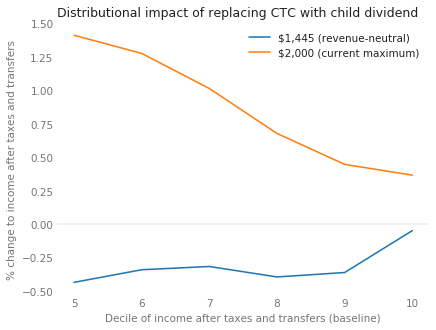

In [327]:
ax = dec[4:].plot(y=['ubi_afti_pctchg', 'tubi_afti_pctchg'])
ax.legend(['$1,445 (revenue-neutral)', '$2,000 (current maximum)'])
plt.axhline(y=0, c='gray', linestyle='dashed', linewidth=0.3, zorder=-1)
sns.despine(left=True, bottom=True)
ax.set(xlabel='Decile of income after taxes and transfers (baseline)',
       ylabel='% change to income after taxes and transfers')
plt.title('Distributional impact of replacing CTC with child dividend', loc='left')
plt.show()

#### Upper 75% in ventiles

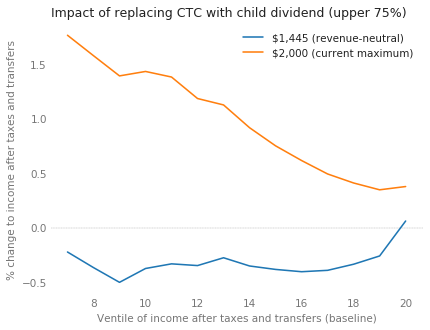

In [328]:
ax = vent[6:].plot(y=['ubi_afti_pctchg', 'tubi_afti_pctchg'])
ax.legend(['$1,445 (revenue-neutral)', '$2,000 (current maximum)'])
plt.axhline(y=0, c='gray', linestyle='dashed', linewidth=0.3, zorder=-1)
sns.despine(left=True, bottom=True)
ax.set(xlabel='Ventile of income after taxes and transfers (baseline)',
       ylabel='% change to income after taxes and transfers') #,
#        yticks=[0, 5, 10, 15, 20, 25])
plt.title('Impact of replacing CTC with child dividend (upper 75%)', loc='left')
plt.show()

Overall deciles (replaced with quartiles).

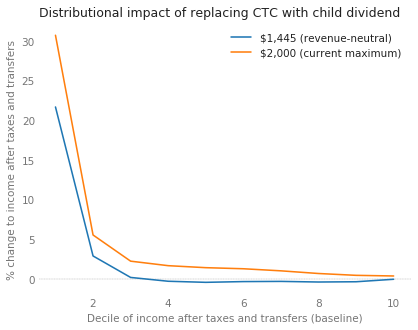

In [329]:
ax = dec.plot(y=['ubi_afti_pctchg', 'tubi_afti_pctchg'])
ax.legend(['$1,445 (revenue-neutral)', '$2,000 (current maximum)'])
plt.axhline(y=0, c='gray', linestyle='dashed', linewidth=0.3, zorder=-1)
sns.despine(left=True, bottom=True)
ax.set(xlabel='Decile of income after taxes and transfers (baseline)',
       ylabel='% change to income after taxes and transfers') #,
#        yticks=[0, 5, 10, 15, 20, 25])
plt.title('Distributional impact of replacing CTC with child dividend', loc='left')
plt.show()

#### Bottom decile by percentile.

Too big an effect for bottom 1-2% to report.

In [114]:
pct.loc[:30, 'ubi_afti_pctchg']

aftertax_income_percentile
1     3.8e+04
2     2.4e+02
3     7.9e+01
4     4.5e+01
5     3.0e+01
6     2.3e+01
7     1.3e+01
8     1.0e+01
9     7.9e+00
10    7.1e+00
11    5.3e+00
12    4.2e+00
13    3.9e+00
14    2.9e+00
15    3.3e+00
16    3.2e+00
17    2.1e+00
18    2.6e+00
19    2.0e+00
20    1.2e+00
21    1.6e-01
22    1.2e+00
23    5.8e-01
24    6.0e-01
25    8.6e-02
26   -3.3e-01
27    1.8e-01
28    1.0e-01
29    1.6e-01
30   -7.1e-01
Name: ubi_afti_pctchg, dtype: float64

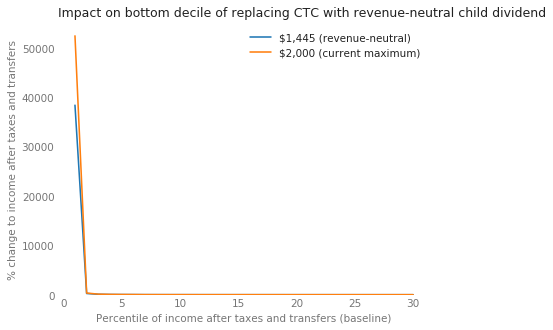

In [330]:
ax = pct[:30].plot(y=['ubi_afti_pctchg', 'tubi_afti_pctchg'])
ax.legend(['$1,445 (revenue-neutral)', '$2,000 (current maximum)'])
sns.despine(left=True, bottom=True)
ax.set(xlabel='Percentile of income after taxes and transfers (baseline)',
       ylabel='% change to income after taxes and transfers',
       ylim=0)
plt.title('Impact on bottom decile of replacing CTC with revenue-neutral child dividend', loc='left')
plt.show()

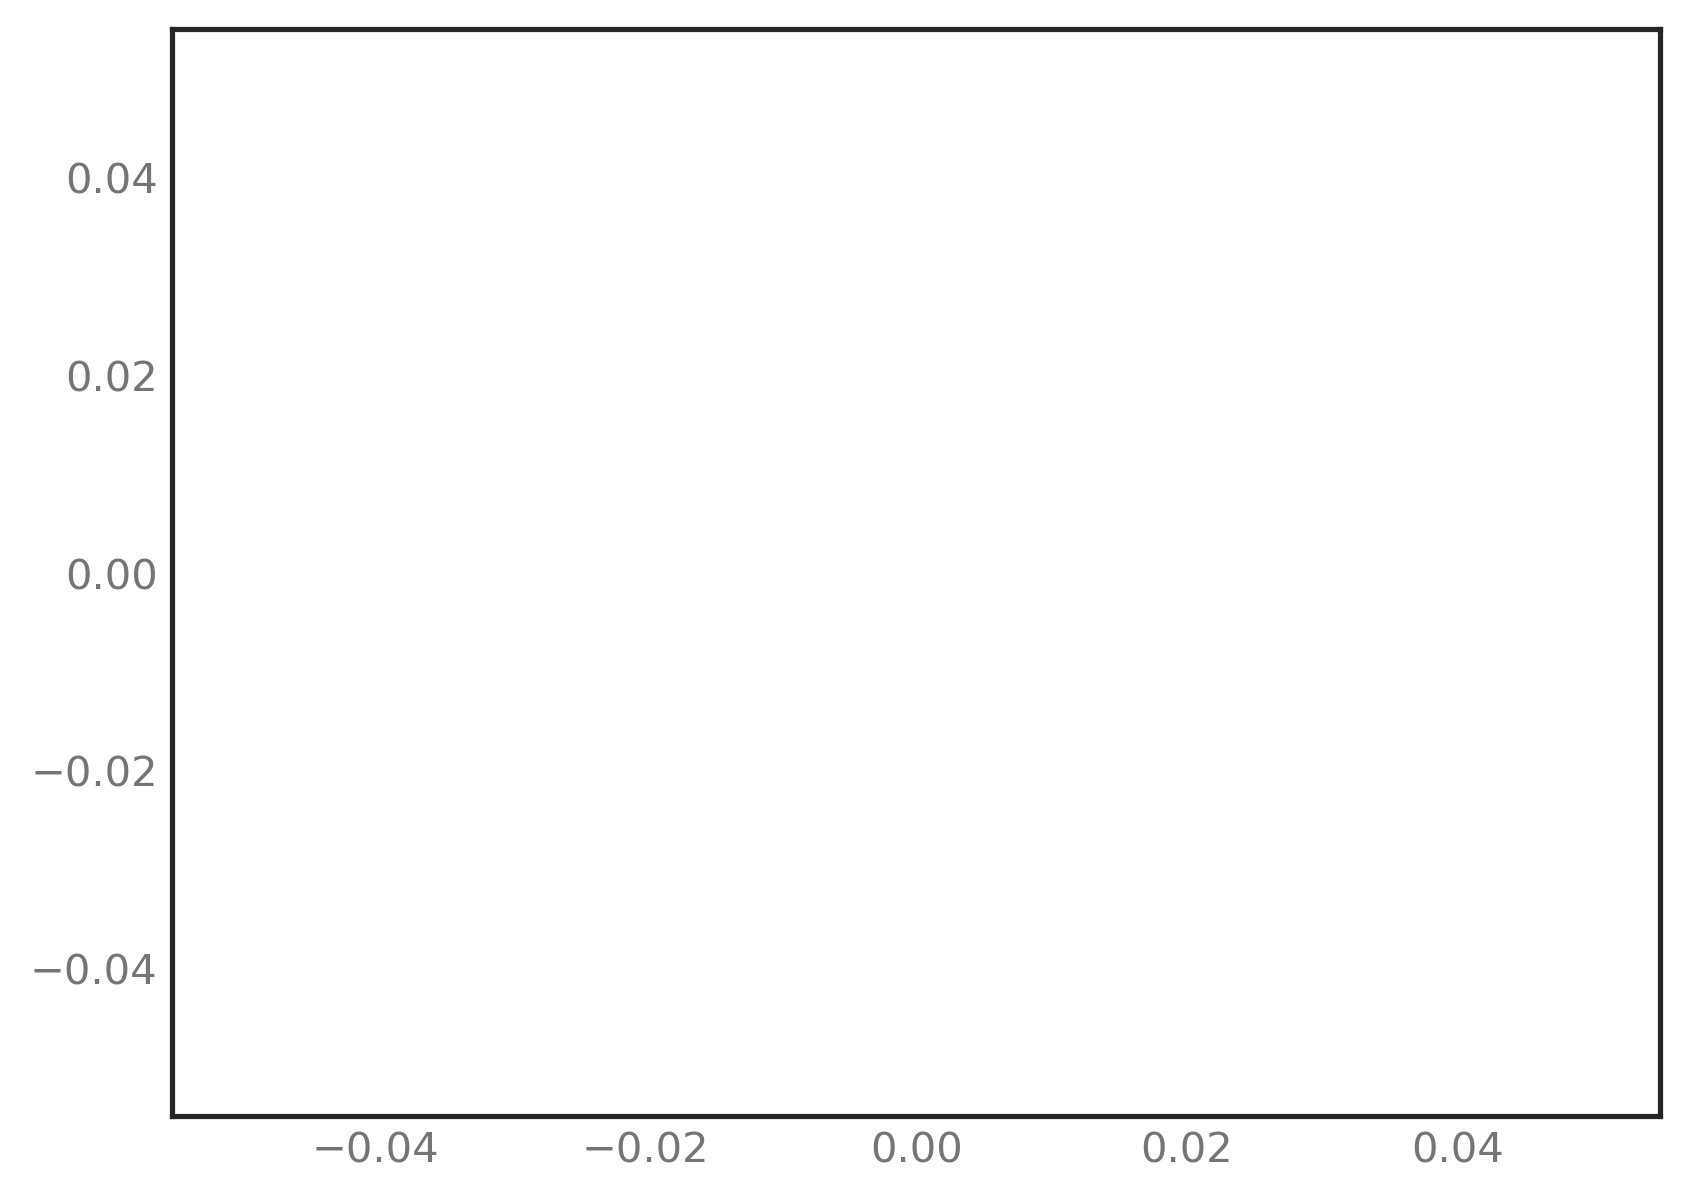

In [559]:
plt.plot(x=1.5, y=5)
plt.show()